## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
##  Camera Calibration Using Chessboard Images

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import csv

In [ ]:
# Calibrate camera based on chessboard images

%matplotlib qt
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

cnt = 1
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        #uncomment this section to show and or write images to disk
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #if (cnt == 4) | (cnt == 9):
        #    cv2.imwrite('./output_images/chess'+str(cnt)+'.jpg', img)
        
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
    cnt+=1
cv2.destroyAllWindows()
 

## Calibrate Camera With Chessboard Data

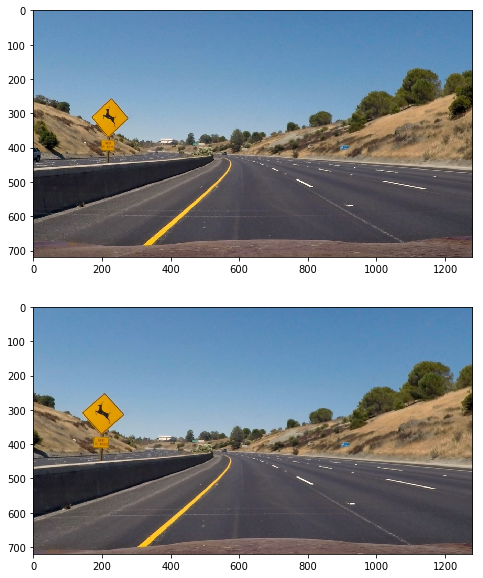

In [3]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('output_images/Undistorted_chessboard.jpg',dst)

#test calibration on test_image
img_test = cv2.imread('./test_images/test2.jpg')
img_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2BGR)

img_dst = cv2.undistort(img_test, mtx, dist, None, mtx)
#cv2.imwrite('./output_images/Unistorted_Image.jpg', img_dst)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(img_test)
plt.subplot(2,1,2)
plt.imshow(img_dst)




## Line() Class to Store and Handle Line Fitting and Curve Radius Calculations

In [48]:
class Line():
    def __init__(self):

        self.n_data_pts = 3
        self.lane_index = 0
        self.curve_index = 0        
        self.n_counter = 0
        
        self.left_fit = 0
        self.right_fit = 0
        self.left_fit_cr = 0
        self.right_fit_cr = 0
        
        self.y_eval =0
        
        self.left_fitx = 0
        self.right_fitx = 0
        self.A_poly_avg =0
        self.B_poly_avg = 0
       
                  
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # was the line detected in the last iteration?
        self.detected = False  
        self.number_detects = 0
        # x values of the last n fits of the line
        self.lane_lines_left =np.zeros((self.n_data_pts,3), dtype=np.float32)
        self.lane_lines_right =np.zeros((self.n_data_pts,3), dtype=np.float32)
        #average x values of the fitted line over the last n iterations
        self.avg_lane_lines = None     
        # most recent 5 curves
        self.recent_curve = np.zeros((self.n_data_pts), dtype=np.float32)
        # avg of last 5 curves
        self.avg_curve = 0
        
    def left_right_fit(self, lefty, leftx, righty, rightx):
        if(self.n_counter < self.n_data_pts):
            self.n_counter += 1
            
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        if (self.left_fit != None) & (self.right_fit != None):
            self.detected = True
        
        
        # add lane_lines polynomials to respective circ buffer
        self.add_lane_lines()
        # set Curve polynomials
        self.A_poly_avg = (self.left_fit_cr[0]+self.right_fit_cr[0])/2
        self.B_poly_avg = (self.left_fit_cr[1]+self.right_fit_cr[1])/2
        # add curve to circular buffer
        self.add_radius()
        
        
    
    def get_left_right_fit(self):
        return self.left_fit, self.right_fit
    
    # gets avg lane_lines and fit's polynomial to it
    def fitx(self, ploty):
        self.y_eval = np.amax(ploty)
        lf_, rt_ = self.get_avg_lane_lines()
        
        self.left_fitx = lf_[0]*ploty**2 + lf_[1]*ploty + lf_[2]
        self.right_fitx = rt_[0]*ploty**2 + rt_[1]*ploty + rt_[2]
        #self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        #self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
            
        
    def get_lane_lines(self):
        return [self.left_fitx, self.right_fitx]
            
            
    # helper functions
    def add_lane_lines(self):
                        
        self.lane_lines_left[self.lane_index] = self.left_fit
        self.lane_lines_right[self.lane_index] = self.right_fit
        self.lane_index +=1
        if(self.lane_index >= self.n_data_pts):
            self.lane_index =0
        
            
        # get average left and right fit lines
    def get_avg_lane_lines(self):
        if(self.n_counter >= self.n_data_pts):
            avg_left = np.average(self.lane_lines_left, axis=0)
            avg_right= np.average(self.lane_lines_right, axis=0)
        else:
            avg_left = np.sum(self.lane_lines_left, axis= 0)/self.n_counter
            avg_right= np.sum(self.lane_lines_right, axis=0)/self.n_counter
        return avg_left, avg_right
            
            
    def add_radius(self):
        # calculate current radius of curve
        curve  = ( (1+ (2*self.A_poly_avg*self.y_eval*self.ym_per_pix + self.B_poly_avg)**2 )**1.5  )/np.absolute(2*self.A_poly_avg)
        #shift recent_curve array data and add new curve data at last index
        self.recent_curve = np.roll(self.recent_curve, self.n_data_pts-1)
        self.recent_curve[self.n_data_pts -1]= curve
        
        #calculate weighted avg of radius and store in avg_curve variable
        sum = 0
        div = np.sum(np.arange(1,self.n_data_pts+1))
        for w in np.arange(self.n_data_pts):
            sum += (w+1)*self.recent_curve[w]
        
        self.avg_curve = sum/div
        ''' 
        self.recent_curve[self.curve_index] = curve
        self.curve_index += 1
        if( self.curve_index >= self.n_data_pts):
            self.curve_index = 0
        
        if( self.n_counter < self.n_data_pts):
            self.avg_curve = np.sum(self.recent_curve)/self.n_counter
        else:
            self.avg_curve = np.average(self.recent_curve)
        '''     
                
    def get_avg_radius():
        return self.avg_curve







## Functions for Image Manipulation

In [47]:
# Functions


"""
    Creates a 3-D black-and-White image, with values of 0 and 255, by first transforming RGB image to HLS color-space,
    then performs sobel operator on L-channel and thresholds/scales  image to 255
    Performs thresholding of S-channel image and scales to 255
    
    Arguments: 
        img- 3-D image to be converted to binary
        s_thresh: high and low threshold points for S-channel image
        sx_thresh: high and low threshold points for L-channel image, 

    Returns a 3-D "Black-and-white", thresholded image 
        
    # code taken from Lesson 15, section 30 of Udacity Self-driving Car, Term1
"""

# define function to create binary images
def get_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #print(np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

"""
    Creates a binary images base on color segmentation of yellow and white
    Argumens: img - 3-D RGB image
    
    returns a 1-D binary image

"""
def get_color_2_binary(img):
    factor = 10
    # lower and upper values for yellow in HSV
    lower_y = np.array([30-factor,50,50])
    upper_y = np.array([30+factor,255,255])
    #lower and upper values for white in RGB
    lower_w = np.array([235,235,235])
    upper_w = np.array([255,255,255])
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask_y = cv2.inRange(hsv, lower_y, upper_y)
    mask_w = cv2.inRange(img, lower_w, upper_w)
    bit_img = mask_y | mask_w #np.bitwise_or(mask_y, mask_w)
    ''' 
    plt.figure()
    plt.imshow(mask_y, cmap='gray')
    plt.figure()
    plt.imshow(mask_w, cmap='gray')
    ''' 
    return bit_img

"""
    Applies an image mask on image to create a Region-Of-Interest (ROI).
    img - image to be segmented
    vertices - Area defining the ROI
    
    returns masked_image - ROI defined by vertices
"""
def region_of_interest(img, vertices):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #defining a blank mask to start with
    #mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

"""
    Smooths image with Gaussian filter and reduces noised a morphological opening
    Arguments:
        image - 1-Dimensional, binary image

    Returns: opening, a "cleaned" version of the 1-D, binary input image
"""

def clean_img(img):
    ksize = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    blur = cv2.GaussianBlur(img,(ksize, ksize),0)
    #erosion = cv2.dilate(blur, kernel,iterations=iterate)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening


def undistort_img(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
        
"""
    performs perspective transformation bases on matrix M, calculated from input source and detination points
    Arguments: 
        img - 1-d or 3-D image
        src - four sets initial (starting) of (x, y) points used to caclutate the transformation matrix
        dst - four end point fo the trans matrix, points must correspond to src
    Returns: warped- transformed image of img
"""    
def warp_img(img, src, dst):
    shape= img.shape
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (shape[1], shape[0]), flags=cv2.INTER_LINEAR)
    return warped



## Functions For Lane Detection and Marking

In [11]:
### code taken from Lesson 15, of Udacity Self-driving Car, Term1

# find_lane_lines() takes in a warped function, calculates polynmial to fit the left 
# and right lane lines

# returns calculated arrays of left and right lane lines and corresponding y-axis points

def find_lane_lines(warped_image):
# find lane lines 
    
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
    histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
# Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_image.shape[0] - (window+1)*window_height
        win_y_high = warped_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    Curve_data.left_right_fit(lefty,leftx, righty, rightx)
         
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    Curve_data.fitx(ploty)
    
    
    #left_curve_rad = ( (1+ (2*left_fit_cr[0]*y_eval*Curve_data.ym_per_pix + left_fit_cr[1])**2 )**1.5  )/np.absolute(2*left_fit_cr[0])
    #right_curve_rad = ( (1+ (2*right_fit_cr[0]*y_eval*Curve_data.ym_per_pix + right_fit_cr[1])**2 )**1.5  )/np.absolute(2*right_fit_cr[0])
    #center_curve_rad = ( (1+ (2*A_poly_avg*y_eval*Curve_data.ym_per_pix + B_poly_avg)**2 )**1.5  )/np.absolute(2*A_poly_avg)
    #Curve_data.add_radius()
    
    
    ##  print(left_curve_rad, 'm  ', right_curve_rad, 'm   ', center_curve_rad, 'm' )
    #print(Curve_data.get_avg_radius, 'm')
    
    #return left and right pts for each warped lane line
    lf_lane, rt_lane = Curve_data.get_lane_lines()
    
    return lf_lane, rt_lane, ploty


### code taken from Lesson 15, of Udacity Self-driving Car, Term1

def find_lane_lines_quick(warped_image):
    
    
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (Curve_data.left_fit[0]*(nonzeroy**2) + Curve_data.left_fit[1]*nonzeroy + \
    Curve_data.left_fit[2] - margin)) & (nonzerox < (Curve_data.left_fit[0]*(nonzeroy**2) + \
    Curve_data.left_fit[1]*nonzeroy + Curve_data.left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (Curve_data.right_fit[0]*(nonzeroy**2) + Curve_data.right_fit[1]*nonzeroy + \
    Curve_data.right_fit[2] - margin)) & (nonzerox < (Curve_data.right_fit[0]*(nonzeroy**2) + 
    Curve_data.right_fit[1]*nonzeroy + Curve_data.right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ''' 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fit_cr = np.polyfit(lefty*Curve_data.ym_per_pix, leftx*Curve_data.xm_per_pix, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    right_fit_cr = np.polyfit(righty*Curve_data.ym_per_pix, rightx*Curve_data.xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # find Curve
    A_poly_avg = (left_fit_cr[0]+right_fit_cr[0])/2
    B_poly_avg = (left_fit_cr[1]+right_fit_cr[1])/2
    left_curve_rad = ( (1+ (2*left_fit_cr[0]*y_eval*Curve_data.ym_per_pix + left_fit_cr[1])**2 )**1.5  )/np.absolute(2*left_fit_cr[0])
    right_curve_rad = ( (1+ (2*right_fit_cr[0]*y_eval*Curve_data.ym_per_pix + right_fit_cr[1])**2 )**1.5  )/np.absolute(2*right_fit_cr[0])
    center_curve_rad = ( (1+ (2*A_poly_avg*y_eval*Curve_data.ym_per_pix + B_poly_avg)**2 )**1.5  )/np.absolute(2*A_poly_avg)
    '''
    Curve_data.left_right_fit(lefty,leftx, righty, rightx)
         
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    Curve_data.fitx(ploty)
    
    #return left and right pts for each warped lane line
    lf_lane, rt_lane = Curve_data.get_lane_lines()
    
    
    return lf_lane, rt_lane, ploty

# fills in area between two lines, from arrays output from find_lane_lines()
# input arg: 
#      warped_image - distorted image
#      color_image - original rgb image 
#      left_fitx, right_fitx, ploty - returned values from find_lane_lines()
#
#  returns rgb image with lanes filled 

def fill_lane(warped_image, color_image, left_fitx, right_fitx, ploty):
# code from https://discussions.udacity.com/t/lane-area-plot-problem/317158/4
    # to format arrays correctly for cv2.polyfill()
    warp_zero = np.zeros_like(warped_image).astype(np.uint8) 
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # undistort image back
    unwarp_image = warp_img(color_warp, dst_pts, src_pts)
    result = cv2.addWeighted(color_image, 1, unwarp_image, 0.3, 0)
    #return's rgb image with lane filled between lane lines
    return result #unwarp_image + color_image


## Color Space Visualization

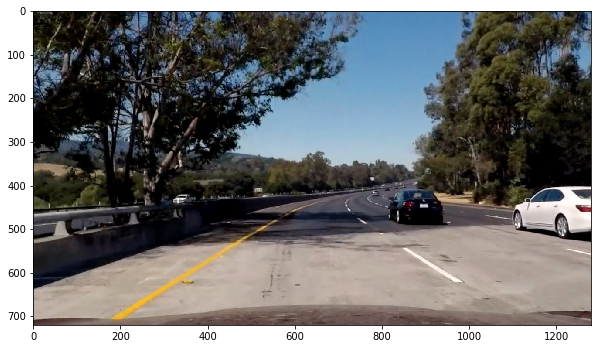

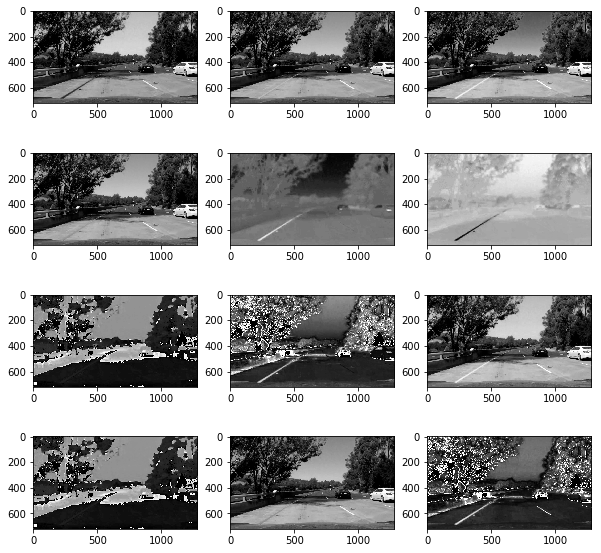

In [12]:
# view test image in diff color spaces: BGR, YUV, HSV, HSL

bgr = cv2.imread('test_images/test5.jpg')
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

rgb = undistort_img(rgb, mtx,dist)

yuv = cv2.cvtColor(bgr, cv2.COLOR_BGR2YUV)
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
hls  = cv2.cvtColor(bgr, cv2.COLOR_BGR2HLS)


images_list = [bgr, yuv, hsv, hls]
subplot_num= 1
plt.figure(figsize=(10,10))
plt.imshow(rgb)
plt.figure(figsize=(10,10))

for im in images_list:
    for index in list(range(0,3)):
        plt.subplot(4,3,subplot_num)
        subplot_num +=1
        plt.imshow(im[:,:,index], cmap='gray')

plt.show()        

In [32]:
"""
factor = 10
T=(170,255)
hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
l = hls[:,:,2]
y = np.uint8([[[255,255,0]]])
w = np.uint8([[[255,255,255]]])
hsv_y = cv2.cvtColor(y, cv2.COLOR_RGB2HSV)
hsv_w = cv2.cvtColor(w, cv2.COLOR_RGB2HSV)
hls_w = cv2.cvtColor(w, cv2.COLOR_RGB2HLS)
print(hsv_y)
print(hsv_w)
print(hls_w)
lower_y = np.array([30-10,50,50])
upper_y = np.array([30+10,255,255])
lower_w = np.array([235,235,235])
upper_w = np.array([255,255,255])

mask1 = cv2.inRange(hsv, lower_y, upper_y)
mask2 = cv2.inRange(rgb, lower_w, upper_w)

bit = np.bitwise_or(mask1, mask2)
plt.imshow(mask1, cmap='gray')
plt.figure()
plt.imshow(mask2, cmap='gray')
plt.figure()
plt.imshow(bit, cmap='gray')
"""
def get_color_2_binary(img):
    factor = 10
    # lower and upper values for yellow in HSV
    lower_y = np.array([30-factor,50,50])
    upper_y = np.array([30+factor,255,255])
    #lower and upper values for white in RGB
    lower_w = np.array([235,235,235])
    upper_w = np.array([255,255,255])
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask_y = cv2.inRange(hsv, lower_y, upper_y)
    mask_w = cv2.inRange(img, lower_w, upper_w)
    bit_img = mask_y | mask_w #np.bitwise_or(mask_y, mask_w)
    ''' 
    plt.figure()
    plt.imshow(mask_y, cmap='gray')
    plt.figure()
    plt.imshow(mask_w, cmap='gray')
    ''' 
    return bit_img
"""     
bit_im2 = get_color_2_binary(rgb)    

plt.figure()
plt.imshow(bit_im2, cmap='gray')
"""

"     \nbit_im2 = get_color_2_binary(rgb)    \n\nplt.figure()\nplt.imshow(bit_im2, cmap='gray')\n"

In [ ]:
print(rgb.shape)

In [ ]:
v = np.copy(hsv[:,:,2])
veq = cv2.equalizeHist(v)

bv= np.zeros_like(v)
bv[]


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(v, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(veq, cmap='gray')

## Lane Finding Pipeline

/home/julie/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


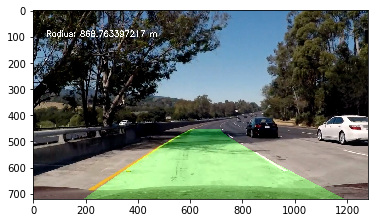

In [14]:
#instantiate class         
Curve_data = Line()   

vertices = np.array([[[ [100,680],[540,400], [740,400],  [1180,680]  ] ]], dtype= np.int32 )
src_pts= np.float32([ [490, 360.0+150], [790, 360.0+150], [250, 670], [1030, 670] ])
dst_pts = np.float32( [[340,470],[1180,470],[375,670], [1180,670] ])
font = cv2.FONT_HERSHEY_SIMPLEX

bgr = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

frame = cv2.undistort(image, mtx, dist, None, mtx)
roi_img = region_of_interest(frame, vertices)

img_bin = get_binary(roi_img, s_thresh=(100, 255), sx_thresh=(50, 255))

b1 = img_bin[:,:,1]
b2 = img_bin[:,:,2]
b = b1 | b2

#b = get_color_2_binary(roi_img)
warped_image = warp_img(b, src_pts, dst_pts)
lf_lane,rt_lane, ploty = find_lane_lines(warped_image)
"""
if Curve_data.detected == False:
    lf_lane,rt_lane, ploty = find_lane_lines(warped_image)
else:
    lf_lane, rt_lane, ploty = find_lane_lines_quick(warped_image)
"""    

lane_image = fill_lane(warped_image, frame, lf_lane, rt_lane, ploty)

text= 'Radius: '+str(Curve_data.avg_curve )+ ' m'
cv2.putText(lane_image, text,(50,100), font, 1,(255,255,255),2,cv2.LINE_AA)

plt.figure()
plt.imshow(lane_image)

In [46]:
#instantiate class         
Curve_data = Line()   

vertices = np.array([[[ [100,680],[540,400], [740,400],  [1180,680]  ] ]], dtype= np.int32 )
src_pts= np.float32([ [490, 360.0+150], [790, 360.0+150], [250, 670], [1030, 670] ])
dst_pts = np.float32( [[340,470],[1180,470],[375,670], [1180,670] ])
font = cv2.FONT_HERSHEY_SIMPLEX

def pipeline(image):
    frame = cv2.undistort(image, mtx, dist, None, mtx)
    mask = region_of_interest(frame, vertices)
    
    img_bin = get_binary(mask, s_thresh=(100, 255), sx_thresh=(50, 255))
    b1 = img_bin[:,:,1]
    b2 = img_bin[:,:,2]
    b = b1 | b2
    
    #b = get_color_2_binary(mask)
    warped_image = warp_img(b, src_pts, dst_pts)
    lf_lane,rt_lane, ploty = find_lane_lines(warped_image)
    '''
    if Curve_data.detected == False:
        lf_lane,rt_lane, ploty = find_lane_lines(warped_image)
    else:
        lf_lane, rt_lane, ploty = find_lane_lines_quick(warped_image)
    '''
    lane_image = fill_lane(warped_image, frame, lf_lane, rt_lane, ploty)

    text= 'Radius: '+str(Curve_data.avg_curve )+ ' m'
    cv2.putText(lane_image, text,(50,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return lane_image

In [45]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'output_images/p3_video01.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)
#clip.write_videofile('myvid.webm', codec='libvpx')

[MoviePy] >>>> Building video output_images/p3_video04.mp4
[MoviePy] Writing video output_images/p3_video04.mp4



 24%|██▍       | 302/1261 [00:23<01:11, 13.36it/s]


 47%|████▋     | 598/1261 [00:46<00:50, 13.06it/s]

TypeError: expected non-empty vector for x


 47%|████▋     | 598/1261 [01:06<01:13,  9.06it/s]

In [42]:
video_output = 'output_images/p3_video01.mp4'

In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))
